




![](https://res.cloudinary.com/monday-blogs/w_768,h_384,c_fit/fl_lossy,f_auto,q_auto/wp-blog/2021/05/sales-forecasting-software.jpg)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
#Import dataset
data = pd.read_csv('Wholesale.csv')
#check the
data.copy()
#set consistency of our dataframe for datetime format
data = data.set_index(['Datetime'])
#To convert the string datetime into string object type rather than datetime object
data.index = pd.to_datetime(data.index)

In [3]:
#to check data info.
data.info()
#check the data set for any nan
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40321 entries, 2018-01-01 00:00:00 to 2022-09-08 00:00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Hours      40321 non-null  int64  
 1   Wholesale  40321 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 945.0 KB


Hours        0
Wholesale    0
dtype: int64

In [4]:
#check the datatypes
data.dtypes

Hours          int64
Wholesale    float64
dtype: object

In [5]:
#quick way to separate numeric columns
data.describe().columns

Index(['Hours', 'Wholesale'], dtype='object')

In [6]:
# to better understand the numeric data, we want to use the .describe() method. This gives us an understanding of the central tendencies of the data 
specific_data = data.describe()
specific_data

,Hours,Wholesale
count,40321.000000,40321.000000
mean,20161.000000,80.801725
std,11639.814439,80.034632
min,1.000000,-50.000000
25%,10081.000000,39.210000
50%,20161.000000,53.380000
75%,30241.000000,84.960000
max,40321.000000,2500.010000


In [7]:
#Drop the unnecessary data
data = data.drop(['Hours'], axis=1)
data

,Wholesale
Datetime,
2018-01-01 00:00:00,42.94
2018-01-01 01:00:00,47.14
2018-01-01 02:00:00,54.60
2018-01-01 03:00:00,46.63
2018-01-01 04:00:00,39.90
...,...
2022-08-08 20:00:00,468.37
2022-08-08 21:00:00,434.44
2022-08-08 22:00:00,416.64


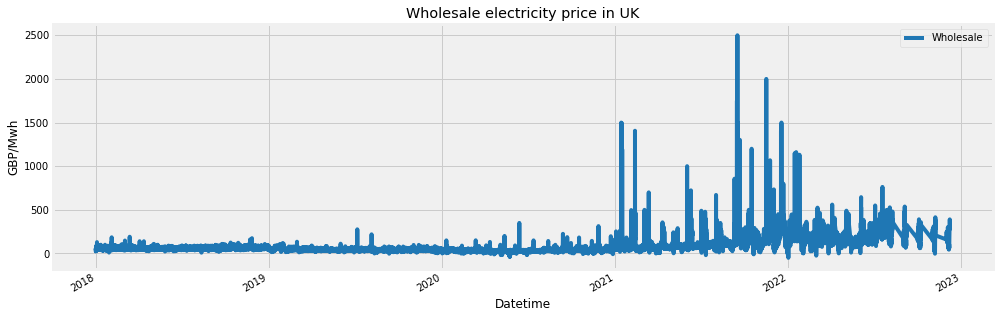

In [8]:
#create graph to visual dataset
data.plot(figsize=(15, 5), color=color_pal[0], title='Wholesale electricity price in UK')
plt.ylabel('GBP/Mwh')
plt.show()

# 1. Outlier Analysis and removal

<AxesSubplot:ylabel='Frequency'>

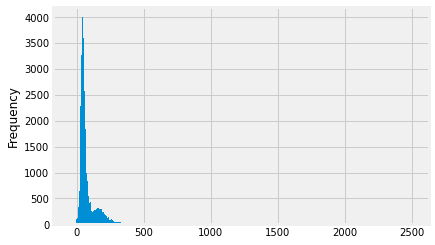

In [9]:
data['Wholesale'].plot(kind='hist', bins=500)

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

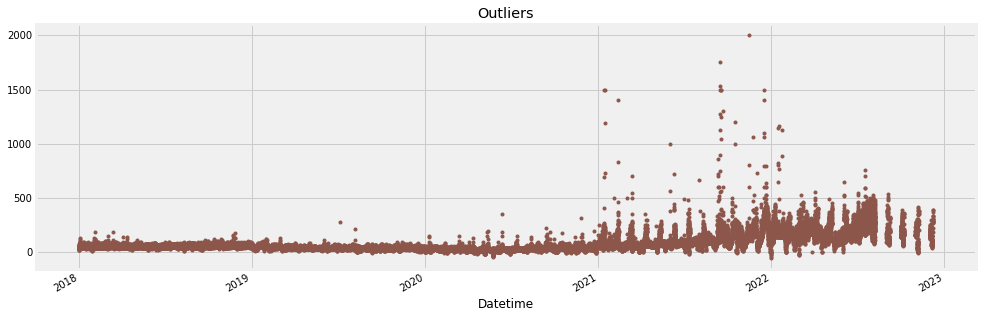

In [10]:
data.query('Wholesale < 2500')['Wholesale'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [11]:
df = data.query('Wholesale > 2500').copy()

# Reviewing: Train / Test Split

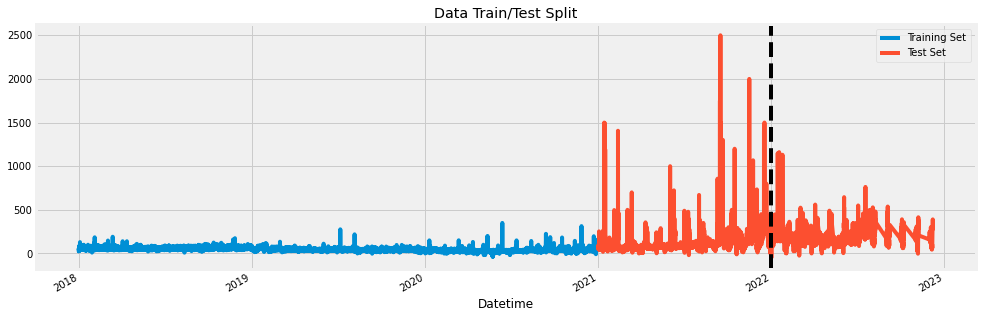

In [12]:
train = data.loc[data.index < '01-01-2021']
test = data.loc[data.index >= '01-01-2021']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 1. Time Series Cross Validation

In [13]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=24*365*1, gap=24)
df = data.sort_index()

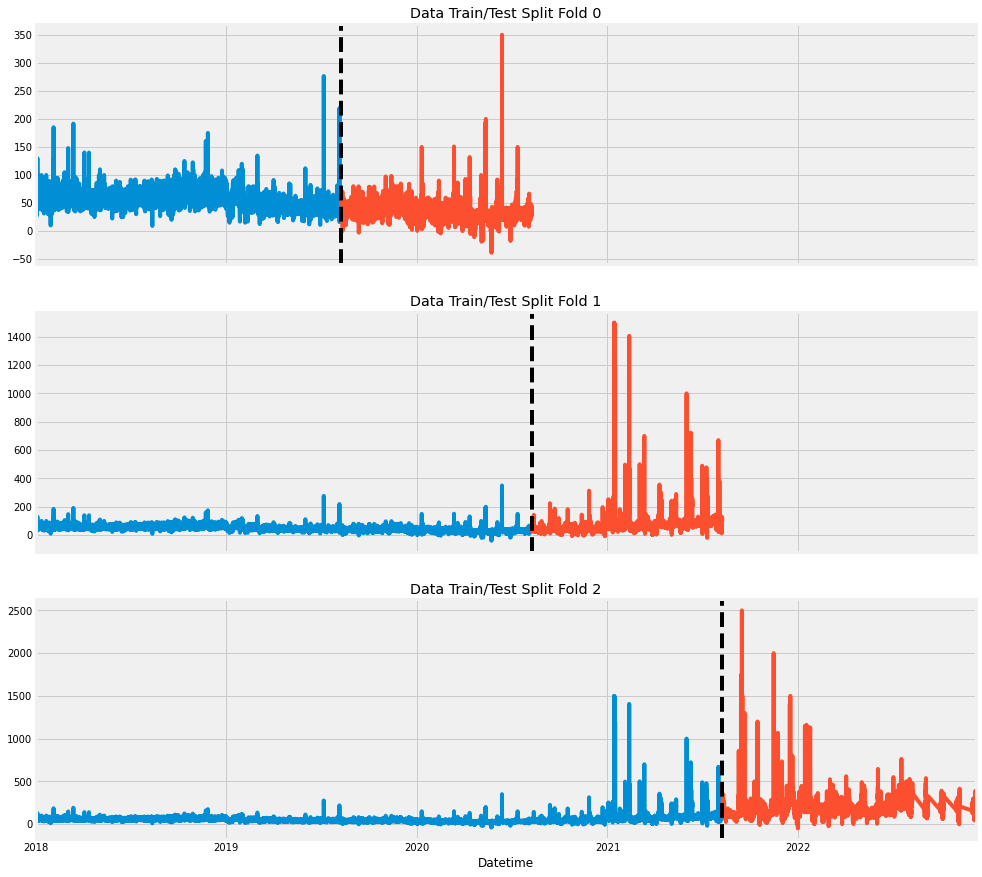

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Wholesale'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Wholesale'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 2. Forecasting Horizon Explained
**The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).**

In [15]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# 3. Lag Features
- What was the target (x) days in the past.

In [16]:
def add_lags(df):
    target_map = df['Wholesale'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [17]:
df = add_lags(df)

## Train Using Cross Validation

In [18]:
tss = TimeSeriesSplit(n_splits=3, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = ['Wholesale']

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[13:22:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:53.51020	validation_1-rmse:36.65318
[100]	validation_0-rmse:21.98253	validation_1-rmse:14.19825
[192]	validation_0-rmse:12.79762	validation_1-rmse:13.36973
[13:22:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:47.76831	validation_1-rmse:88.74577
[100]	validation_0-rmse:20.55403	validation_1-rmse:75.09820
[200]	validation_0-rmse:12.72594	validation_1-rmse:70.74867
[300]	validation_0-rmse:10.97377	validation_1-rmse:69.37783
[400]	validation_0-rmse:10.51856	validation_1-rmse:68.79534
[500]	validation_0-rmse:10.34412	validation_1-rmse:68.65271
[600]	validation_0-rmse:10.21729	validation_1-rm

In [19]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 65.6399
Fold scores:[12.62978113144943, 68.58977339276646, 115.70020925911012]


# 4. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [20]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = ['Wholesale']

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[13:22:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:112.48997
[100]	validation_0-rmse:63.21672
[200]	validation_0-rmse:51.30174
[300]	validation_0-rmse:47.81004
[400]	validation_0-rmse:46.39768
[499]	validation_0-rmse:45.40637


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [21]:
df.index.max()

Timestamp('2022-12-07 23:00:00')

In [22]:
# Create future dataframe
future = pd.date_range('2022-08-09','2023-07-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [23]:
future_w_features = df_and_future.query('isFuture').copy()

## Predict the future

In [24]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features

,Wholesale,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture,pred
2022-08-09 00:00:00,NaN,0,1,3,8,2022,221,9,32,178.00,57.90,39.28,True,303.402252
2022-08-09 01:00:00,NaN,1,1,3,8,2022,221,9,32,159.95,51.90,34.94,True,301.006866
2022-08-09 02:00:00,NaN,2,1,3,8,2022,221,9,32,162.70,45.00,31.99,True,297.346497
2022-08-09 03:00:00,NaN,3,1,3,8,2022,221,9,32,162.02,37.20,31.00,True,280.389252
2022-08-09 04:00:00,NaN,4,1,3,8,2022,221,9,32,159.94,32.90,31.49,True,274.874176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30 20:00:00,NaN,20,4,2,6,2023,181,30,26,254.63,64.05,35.40,True,313.075684
2023-06-30 21:00:00,NaN,21,4,2,6,2023,181,30,26,207.17,55.01,31.99,True,314.030151
2023-06-30 22:00:00,NaN,22,4,2,6,2023,181,30,26,189.08,62.31,28.30,True,321.320221
2023-06-30 23:00:00,NaN,23,4,2,6,2023,181,30,26,190.02,41.69,22.23,True,303.707977


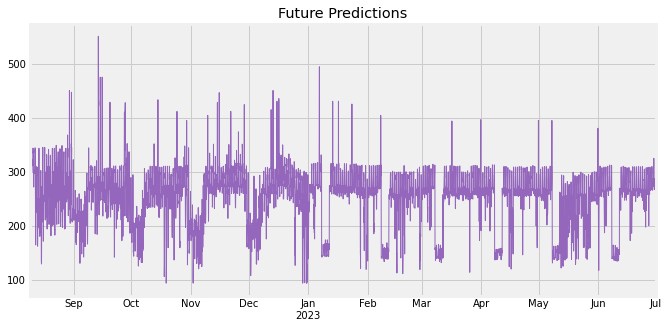

In [25]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# Bonus: Saving Model For later

In [26]:
# Save model
reg.save_model('model.json')

In [27]:
!ls -lh

total 238848
-rw-r--r--@ 1 titiqd  staff   202K Jul 27 00:54 NOrd pool UK 2020.xlsx
-rw-r--r--@ 1 titiqd  staff   595K Jul 27 00:59 Nordpool 2018.xlsx
-rw-r--r--@ 1 titiqd  staff   456K Jul 26 13:30 Nordpool 2018ed.csv
-rw-r--r--@ 1 titiqd  staff   145K Jul 27 00:54 Nordpool 2021-2022.xlsx
-rw-r--r--@ 1 titiqd  staff   565K Aug  8 15:53 Nordpool.csv
-rw-r--r--@ 1 titiqd  staff   174K Aug 12 13:02 Presentation3.png
-rw-r--r--  1 titiqd  staff   489K Aug  7 00:11 Project - Electricity.ipynb
-rw-r--r--  1 titiqd  staff   568K Aug  8 11:37 Project1 - Electricity.ipynb
-rw-r--r--  1 titiqd  staff   836K Aug  9 05:31 Project2 - Electricity.ipynb
-rw-r--r--@ 1 titiqd  staff    88M Jun  3 19:48 Techno-economic study 080321_cp 80%_2019 020222.xlsx
-rw-r--r--@ 1 titiqd  staff   1.1M Aug  9 09:45 Wholesale.csv
-rw-r--r--@ 1 titiqd  staff   1.1M Aug  9 06:45 Wholesale.xlsx
-rw-r--r--  1 titiqd  staff   366K Aug 11 12:14 XGBoost.ipynb
drwxr-xr-x@ 3 titiqd  staff    96B Aug  8 11:34 __pycache__
-rw-

<AxesSubplot:title={'center':'Future Predictions'}>

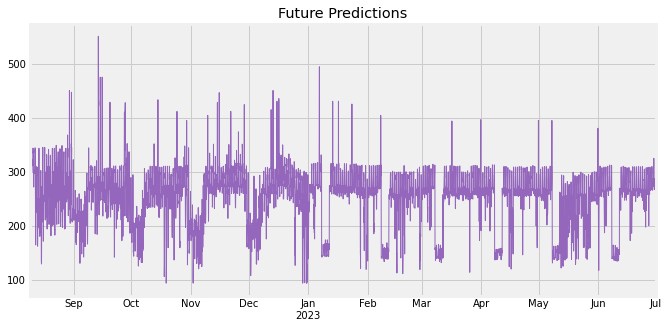

In [28]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

# The End